# 辨識單張圖片
## Step 1: 載入模型
請各位將下列幾項變數給予相對應的參數。

- ARGS_FRAMEWORK (深度學習架構)
    - tf, tflite, trt
- ARGS_WEIGHTS (訓練好的權重路徑)
    - path to weights file
- ARGS_TINY='yolo' (是否壓縮模型)
    - yolo or yolo-tiny
- ARGS_MODEL='yolov4' (Yolo版本)
    - yolov3 or yolov4


In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
import core.utils as utils
from core.yolov4 import filter_boxes
from tensorflow.python.saved_model import tag_constants
from PIL import Image
import cv2
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import matplotlib.pyplot as plt

ARGS_FRAMEWORK='tf' # tf, tflite, trt
ARGS_WEIGHTS='./checkpoints/yolov4-car_final-608' # 'path to weights file'
ARGS_TINY='yolo' # 'yolo or yolo-tiny'
ARGS_MODEL='yolov4' # 'yolov3 or yolov4'


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


saved_model_loaded = tf.saved_model.load(ARGS_WEIGHTS, tags=[tag_constants.SERVING])
infer = saved_model_loaded.signatures['serving_default']

## Step 2: 預測
給與適當的初始化參數，並給定預測圖片的位置。

- ARGS_IMAGE (圖片位置)
    - path to input image
- ARGS_SIZE=512 (輸入影像大小)
    - resize images to
- ARGS_OUTPUT (輸出影像的路徑)
    - path to output image
- ARGS_IOU (iou 閾值)
    - range 0~1
- ARGS_SCORE (信心程度閾值)
    - range 0~1

Execution time:  0.07656693458557129 seconds


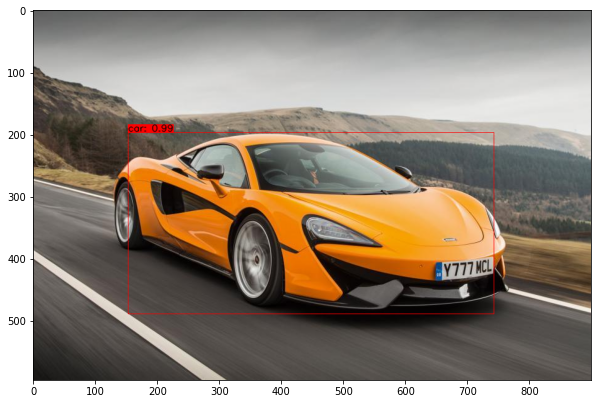

In [6]:
import time
start = time.time()

ARGS_IMAGE='./test2.jpg' # 'path to input image'
ARGS_SIZE=608 # 'resize images to'
ARGS_OUTPUT='result.png' # 'path to output image'
ARGS_IOU=0.45 # 'iou threshold'
ARGS_SCORE=0.25 # 'score threshold'

# 讀取圖片
input_size = ARGS_SIZE
image_path = ARGS_IMAGE

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image_data = cv2.resize(original_image, (input_size, input_size))
image_data = image_data / 255.

images_data = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)



batch_data = tf.constant(images_data)
pred_bbox = infer(batch_data)
for key, value in pred_bbox.items():
    boxes = value[:, :, 0:4]
    pred_conf = value[:, :, 4:]

boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
    scores=tf.reshape(
        pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
    max_output_size_per_class=50,
    max_total_size=50,
    iou_threshold=ARGS_IOU,
    score_threshold=ARGS_SCORE
)
pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
image = utils.draw_bbox(original_image, pred_bbox)
image = Image.fromarray(image.astype(np.uint8))

stop = time.time()
print('Execution time: ', stop - start ,'seconds')  

# 顯示結果
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

## 儲存照片

In [9]:
image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
cv2.imwrite(ARGS_OUTPUT, image)

True

## 客製化進階處理
### 透過 pred_bbox 找到對角點
透過 Yolo 模型輸入一張照片，模型將會回傳 pred_bbox 變數。在 pred_bbox 變數裡面將會分成四個小部分表示，其中 `pred_bbox[0]` 為每一張照片中的對角兩點的x、y座標。`pred_bbox[1]` 為照片中每一個預測框的信心程度。`pred_bbox[2]` 為預測框所相對應的類別。`pred_bbox[3]` 將會回傳每一張照片中找到的 bounding box數量。

如果要取得每張照片中的預測框位置可以從 `out_boxes` 變數取得，此變數將有三個維度。第一個維度為照片張數。由於我們的 batch size=1 代表每次預測僅會回傳一張照片的結果。第二個維度是bounding box數量，由於我們在模型設定 `max_total_size=50` 因此這裡將會有 50 個，如果要查詢有多少個目標候選框數量可以從 `num_boxes` 變數取得。第三個維度為候選框對角兩點的座標，順序為左上y、左上x、左下y、左下x。
> pred_bbox 裡面的 out_boxes 是已經轉回正常影像中的相對位置。不需要再乘以寬高。

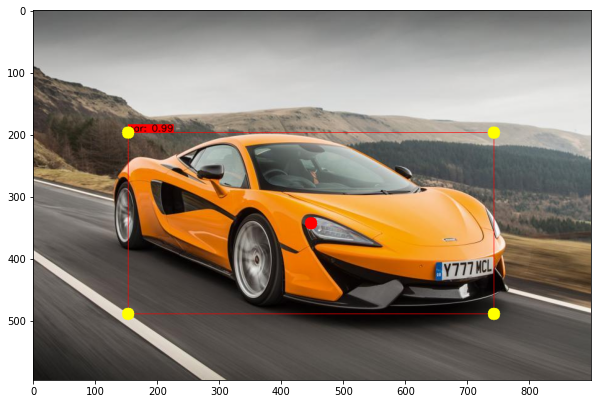

In [7]:
out_boxes, out_scores, out_classes, num_boxes = pred_bbox
# 取得對角兩點
c1, c2, c3, c4 = (out_boxes[0][0][1], out_boxes[0][0][0]), (out_boxes[0][0][3], out_boxes[0][0][2]), (out_boxes[0][0][3], out_boxes[0][0][0]), (out_boxes[0][0][1],out_boxes[0][0][2])
# 繪製左上角點(c1)
cv2.circle(original_image, c1, 10, (255, 255, 0), -1)
# 繪製右下角點(c2)
cv2.circle(original_image, c2, 10, (255, 255, 0), -1)
# 繪製右上角點(c3)
cv2.circle(original_image, c3, 10, (255, 255, 0), -1)
# 繪製左下角點(c4)
cv2.circle(original_image, c4, 10, (255, 255, 0), -1)
# 中心點(c5)
c5 = (int((c1[0]+c2[0])/2), int((c1[1]+c2[1])/2))
cv2.circle(original_image, c5, 10, (255, 0, 0), -1)
plt.figure(figsize=(10, 10))
plt.imshow(original_image)